# <center>Design AlexNet for Cifar-10 Dataset</center>

AlexNet is a deep convolutional neural network, which was initially developed by Alex Krizhevsky and his colleagues back in 2012.

It was designed to classify images for the ImageNet LSVRC-2010 competition where it achieved state of the art results.

[ImageNet Classification with Deep Convolutional
Neural Networks](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf?ref=blog.paperspace.com)

**Summary About AlexNet Network:**
1.  `It operated with 3-channel images that were (224x224x3) in size.`
2. `It used max pooling along with ReLU activations when subsampling`.
3. `The kernels used for convolutions were either 11x11, 5x5, or 3x3.`
4. `While kernels used for max pooling were 3x3 in size`.
5. `It classified images into 1000 classes. It also utilized multiple GPUs.`

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# # cuda - GPU setup
# device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Thu Apr 20 13:37:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## DataLoading

### DataSet

We will use [cifar-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html?ref=blog.paperspace.com) dataset.
- The dataset consists of `60000 32x32 colour images` in `10 classes`, with `6000 images per class`.
- There are `50000 training images` and `10000 test images`.

Here are the classes in the dataset, as well as 10 random images from each: 
* Source: https://www.cs.toronto.edu/%7Ekriz/cifar.html

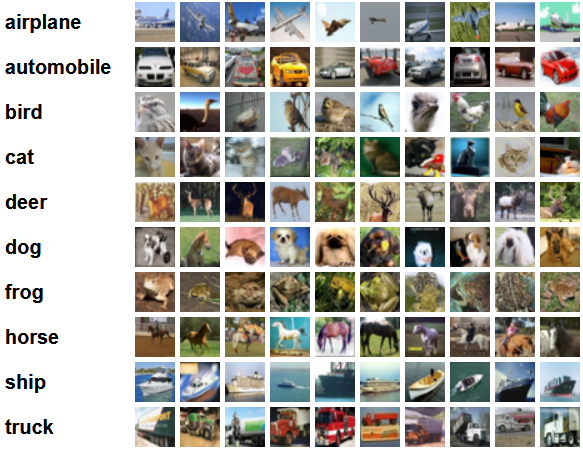

### Loading the Dataset

In [5]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


In [6]:
def get_test_loader(data_dir,batch_size,shuffle=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

In [7]:
# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = 'data', batch_size = 64,augment = True, random_seed = 1)

test_loader = get_test_loader(data_dir = 'data',batch_size = 64)

100%|██████████| 170498071/170498071 [00:13<00:00, 12596691.75it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


## Build AlexNet Architecture/Model

[REFERENCE for Below Image ](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F03%2Fintroduction-to-the-architecture-of-alexnet%2F&psig=AOvVaw2L01GiqGD7JeQRA62Eckgr&ust=1682088505586000&source=images&cd=vfe&ved=0CBEQjRxqFwoTCLCu1JDauP4CFQAAAAAdAAAAABBI)

<img src="https://i.ytimg.com/vi/uNdfM5AJYWU/maxresdefault.jpg"/>

In [8]:
class AlexNet(nn.Module):
  #  Inherits nn.Module as it contains many of the methods that we will need to utilize.

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Initializing the layers that we are going to use in our CNN --

        self.layer1 = nn.Sequential(
            # define the convolutional layers using the nn.Conv2D function with the appropriate kernel size and the input/output channels.
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))  # apply max pooling using nn.MaxPool2D function.

        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # Now, define the fully connected layers :
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)) # Output has 10 classes here in cifar-10 dataset.

    #  Now, define the sequence in which these above layers will process the image--  
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Plotting the above designed AlexNet Model:

In [9]:
from torchsummary import summary

model = AlexNet(num_classes=10)
summary(model, (3, 227, 227), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

In [13]:
# !pip install graphviz

In [ ]:
!pip install torchviz

In [15]:
from torchviz import make_dot

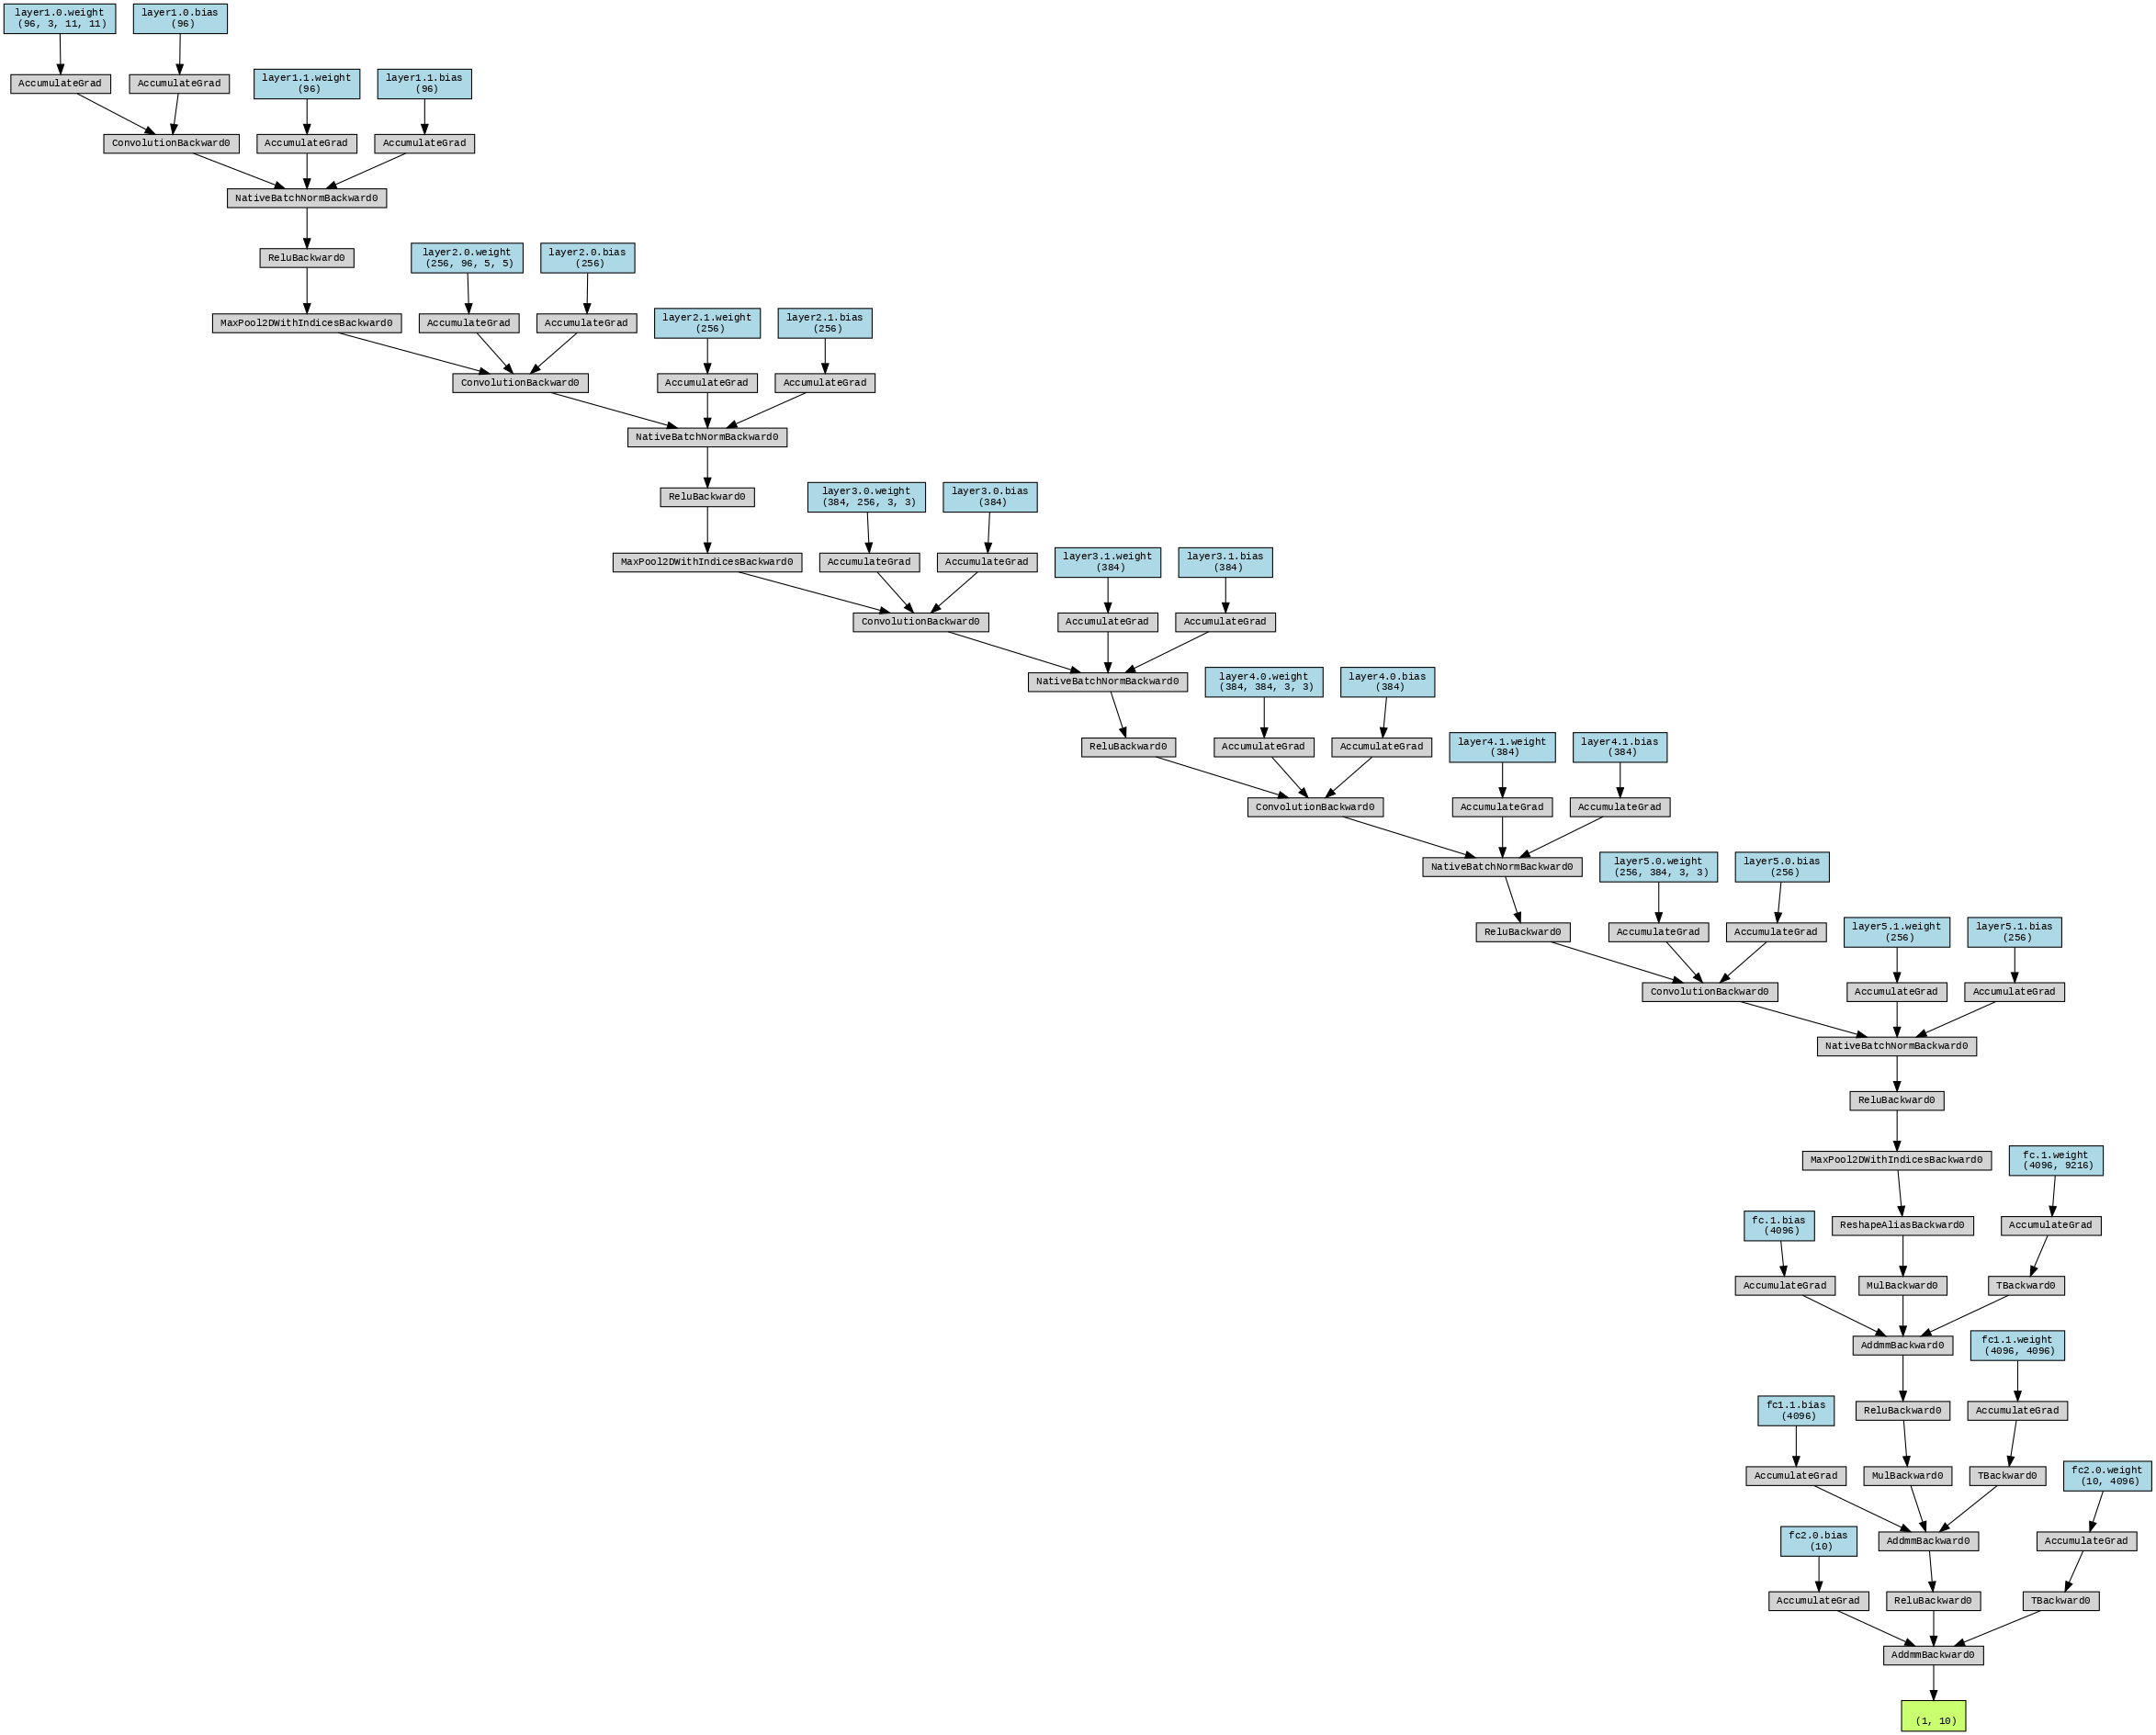

In [16]:
# Create an instance of the AlexNet model
model = AlexNet(num_classes=10)

# # Create a random input tensor
x = torch.randn(1, 3, 227, 227)

from IPython.display import Image

# Use make_dot to visualize the network graph
dot = make_dot(model(x), params=dict(model.named_parameters()))
# dot.render('alexnet', format='png')
dot.format = 'png'
dot.render('alexnet')

# Display the image in Jupyter Notebook
Image(filename='alexnet.png')

In [17]:
# list(model.parameters())
# list(model.named_parameters())

print(f"Model structure: {model}\n\n")

Model structure: AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [18]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}\n")
    # break

Layer: layer1.0.weight | Size: torch.Size([96, 3, 11, 11])

Layer: layer1.0.bias | Size: torch.Size([96])

Layer: layer1.1.weight | Size: torch.Size([96])

Layer: layer1.1.bias | Size: torch.Size([96])

Layer: layer2.0.weight | Size: torch.Size([256, 96, 5, 5])

Layer: layer2.0.bias | Size: torch.Size([256])

Layer: layer2.1.weight | Size: torch.Size([256])

Layer: layer2.1.bias | Size: torch.Size([256])

Layer: layer3.0.weight | Size: torch.Size([384, 256, 3, 3])

Layer: layer3.0.bias | Size: torch.Size([384])

Layer: layer3.1.weight | Size: torch.Size([384])

Layer: layer3.1.bias | Size: torch.Size([384])

Layer: layer4.0.weight | Size: torch.Size([384, 384, 3, 3])

Layer: layer4.0.bias | Size: torch.Size([384])

Layer: layer4.1.weight | Size: torch.Size([384])

Layer: layer4.1.bias | Size: torch.Size([384])

Layer: layer5.0.weight | Size: torch.Size([256, 384, 3, 3])

Layer: layer5.0.bias | Size: torch.Size([256])

Layer: layer5.1.weight | Size: torch.Size([256])

Layer: layer5.1.bi

## Setting Hyperparameters

Before training, we need to set some hyperparameters, such as the loss function and the optimizer to be used along with batch size, learning rate, and number of epochs.

In [19]:
num_classes = 10
num_epochs = 50
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader) # define total_step to keep better track of steps when training

## Training

In [20]:
total_step = len(train_loader)

for epoch in range(num_epochs):

  # start by iterating through the number of epochs, and then the batches in our training data:
    for i, (images, labels) in enumerate(train_loader):  

        # Move tensors to the configured device
        images = images.to(device)   # convert images to devices a/c to CPU or GPU
        labels = labels.to(device)  # convert labels to devices a/c to CPU or GPU
        
        # Forward pass
        outputs = model(images)  #  make predictions using our model and 
        loss = criterion(outputs, labels) # calculate loss based on those predictions and our actual labels.
        
        # Backward and optimize  -- update our weights to improve our model
        optimizer.zero_grad()   # set the gradients to zero before every update
        loss.backward()  #  calculate the new gradients
        optimizer.step()  # update the weights

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    # Also, at the end of every epoch we use our validation set to calculate the accuracy of the model as well:
    with torch.no_grad():
      # we don't need gradients so we use with torch.no_grad() for faster evaluation
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/50], Step [704/704], Loss: 1.4277
Accuracy of the network on the 5000 validation images: 47.2 %
Epoch [2/50], Step [704/704], Loss: 1.4747
Accuracy of the network on the 5000 validation images: 56.18 %
Epoch [3/50], Step [704/704], Loss: 1.3617
Accuracy of the network on the 5000 validation images: 62.02 %
Epoch [4/50], Step [704/704], Loss: 0.9193
Accuracy of the network on the 5000 validation images: 66.06 %
Epoch [5/50], Step [704/704], Loss: 2.4149
Accuracy of the network on the 5000 validation images: 66.72 %
Epoch [6/50], Step [704/704], Loss: 0.5476
Accuracy of the network on the 5000 validation images: 70.42 %
Epoch [7/50], Step [704/704], Loss: 0.3876
Accuracy of the network on the 5000 validation images: 72.04 %
Epoch [8/50], Step [704/704], Loss: 0.4462
Accuracy of the network on the 5000 validation images: 73.24 %
Epoch [9/50], Step [704/704], Loss: 1.3950
Accuracy of the network on the 5000 validation images: 73.18 %
Epoch [10/50], Step [704/704], Loss: 0.3862
Acc

## Testing

In [23]:
# Note: the code is exactly the same as for our validation purposes.
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 78.26 %


## Do Training Again and Model Weights, Loss, Accuracy After Each Epoch

In [26]:
# Re-initialize the model weights again:

num_classes = 10
num_epochs = 50
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader) # define total_step to keep better track of steps when training

In [ ]:
import json
import pandas as pd

# Create empty lists and dictionary
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
weights_dict = {}

total_step = len(train_loader)

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    # start by iterating through the number of epochs, and then the batches in our training data:
    for i, (images, labels) in enumerate(train_loader):  

        # Move tensors to the configured device
        images = images.to(device)   # convert images to devices a/c to CPU or GPU
        labels = labels.to(device)  # convert labels to devices a/c to CPU or GPU
        
        # Forward pass
        outputs = model(images)  #  make predictions using our model and 
        loss = criterion(outputs, labels) # calculate loss based on those predictions and our actual labels.
        
        # Backward and optimize  -- update our weights to improve our model
        optimizer.zero_grad()   # set the gradients to zero before every update
        loss.backward()  #  calculate the new gradients
        optimizer.step()  # update the weights

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        # train_acc = 100 * correct / labels.size(0)
        # train_acc_list.append(train_acc)
        total_samples += labels.size(0)
        total_correct += correct

    # Append training loss and accuracy to lists
    train_loss_list.append(loss.item())
    train_acc_list.append(100 * total_correct / total_samples)

    print('Epoch [{}/{}], Step [{}/{}], acc:{:.4f}, Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, train_acc_list[-1], loss.item()))

    # Validation
    # Also, at the end of every epoch we use our validation set to calculate the accuracy of the model as well:
    with torch.no_grad():
        # we don't need gradients so we use with torch.no_grad() for faster evaluation
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        # Calculate validation accuracy,loss and append to list
        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss/len(valid_loader))
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, val_acc))

    # Store weights of each layer for the current epoch in the dictionary
    for name, param in model.named_parameters():
        if param.requires_grad:
            if epoch not in weights_dict:
                weights_dict[epoch] = {}
            weights_dict[epoch][name] = param.data.tolist()

    # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    

# # Save training loss, accuracy and validation loss, accuracy lists to a JSON file
# result_dict = {"train_loss": train_loss_list, "train_acc": train_acc_list, "val_loss": val_loss_list, "val_acc": val_acc_list}
# with open('/content/results.json', 'w') as outfile:
#     json.dump(result_dict, outfile)

# # Save weights dictionary to a JSON file
# with open('/content/weights.json', 'w') as outfile:
#     json.dump(weights_dict, outfile)

Epoch [1/50], Step [704/704], acc:41.6978, Loss: 0.9191
Accuracy of the network on the 5000 validation images: 48.78 %
Epoch [2/50], Step [704/704], acc:55.8644, Loss: 1.1693
Accuracy of the network on the 5000 validation images: 58.98 %
Epoch [3/50], Step [704/704], acc:62.1289, Loss: 1.3098
Accuracy of the network on the 5000 validation images: 64.28 %
Epoch [4/50], Step [704/704], acc:65.6222, Loss: 0.7014
Accuracy of the network on the 5000 validation images: 66.12 %


In [ ]:
# Save training loss, accuracy and validation loss, accuracy lists to a JSON file
result_dict = {"train_loss": train_loss_list, "train_acc": train_acc_list, "val_loss": val_loss_list, "val_acc": val_acc_list}
with open('/content/results.json', 'w') as outfile:
    json.dump(result_dict, outfile)

# Save weights dictionary to a JSON file
with open('/content/weights.json', 'w') as outfile:
    json.dump(weights_dict, outfile)

### Testing

In [ ]:
# Note: the code is exactly the same as for our validation purposes.
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

### Save above weights and accuracy and loss in a file to google-drive:

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import os

folder_path = '/content/drive/MyDrive/Colab Notebooks/Alexnet'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
import shutil

src_results = 'results.json'
dst_results = os.path.join(folder_path, 'results.json')
shutil.copy(src_results, dst_results)

src_weights = 'weights.json'
dst_weights = os.path.join(folder_path, 'weights.json')
shutil.copy(src_weights, dst_weights)

In [ ]:
# import shutil
# shutil.copy('/content/results.json', '/content/drive/MyDrive/Colab Notebooks/Alexnet/results.json')
# shutil.copy('/content/weights.json', '/content/drive/MyDrive/Colab Notebooks/Alexnet/weights.json')

In [ ]:
# Convert results to pandas DataFrame and show head
import pandas as pd

df = pd.DataFrame(result_dict)
print(df.head())

### Plot Loss,Accuracy vs. #epochs

In [22]:
# PLot ACcuracy and Loss for validation and Training data:

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the results from the JSON file
with open('/content/results.json', 'r') as f:
    results = json.load(f)

# Extract the training loss, validation accuracy, and validation loss
train_loss = results['train_loss']
val_acc = results['val_acc']
val_loss = results['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot the training loss and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot the validation accuracy
ax2.plot(val_acc, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# load the results from the JSON file
with open('/content/results.json', 'r') as f:
    results = json.load(f)

# create a pandas DataFrame from the results dictionary
df = pd.DataFrame(results)

# plot the loss over epochs
plt.plot(df['train_loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

# plot the accuracy over epochs
plt.plot(df['train_acc'], label='Training Accuracy')
plt.plot(df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()

## END